(sw_tomography)=

# Part I: Surface-Wave Tomography

Surface-wave tomography commonly relies on the assumption that surface waves propagate along the great-circle path connecting two points on the Earth's surface. This assumption is motivated by the observation that, at the considered frequency, lateral variations in surface-wave velocity are relatively minor, thus resulting in only slight ray bending. By discretizing the Earth's surface into $N$ blocks, each of constant slowness $s$, and assuming negligible ray bending, the forward equation for the travel time between two points can be expressed as $t = \sum_n^N s_n l_n$, where $l$ denotes the length of the great circle crossing the $n$th block.

In the following, we tackle the surface-wave tomography problem using a trans-dimensional discretization of the Earth's surface, via the 2-D Voronoi tessellation as provided by [bayesbay.discretization.Voronoi2D](../api/generated/bayesbay.discretization.Voronoi2D). 

## Import libraries and define constants

In this tutorial, we make use of the [SeisLib](https://seislib.readthedocs.io/en/latest/) Python library; first to generate a synthetic velocity model and then in the forward calculation of surface-wave arrival times.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from seislib.tomography import SeismicTomography
import seislib.colormaps as scm

from bayesbay.discretization import Voronoi2D
from bayesbay.prior import UniformPrior
import bayesbay as bb

np.random.seed(10)

## True velocity model

Using SeisLib, the following block defines a velocity model characterized by a checkerboard pattern, which we will attempt to retrieve through Bayesian inversion.

In [9]:
tomo = SeismicTomography(
    cell_size=0.005, 
    lonmin=-1, 
    lonmax=1, 
    latmin=-1, 
    latmax=1,
    regular_grid=True
    )
grid_points = np.column_stack(tomo.grid.midpoints_lon_lat())
vel_true = tomo.checkerboard(
    ref_value=3, 
    kx=3, 
    ky=3,
    lonmin=tomo.grid.lonmin,
    lonmax=tomo.grid.lonmax,
    latmin=tomo.grid.latmin,
    latmax=tomo.grid.latmax,
    anom_amp=0.3
    )(*grid_points.T)

-------------------------------------
GRID PARAMETERS
Lonmin - Lonmax : -1.000 - 1.000
Latmin - Latmax : -1.000 - 1.000
Number of cells : 160000
Grid cells of 0.005° : 160000
-------------------------------------


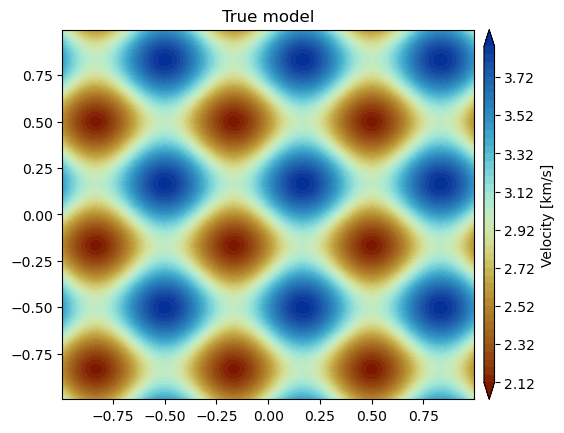

In [3]:
fig, ax = plt.subplots()
img = ax.tricontourf(*grid_points.T, 
                     vel_true, 
                     levels=50, 
                     cmap=scm.roma,
                     vmin=vel_true.min(),
                     vmax=vel_true.max(),
                     extend='both')
ax.set_xlim(grid_points[:,0].min(), grid_points[:,0].max())
ax.set_ylim(grid_points[:,1].min(), grid_points[:,1].max())
cbar = fig.colorbar(img, ax=ax, aspect=35, pad=0.02)
cbar.set_label('Velocity [km/s]')
ax.set_title('True model')
plt.show()

## Observed  Data

The code block below generates coordinates for seismic sources and receivers, positioning 40 sources along the boundary of the previously defined velocity-model region and 50 receivers randomly within it. Utilizing SeisLib, we then compute the $m \times n$ Jacobian matrix $\mathbf{G}$, where $m$ denotes the number of source-receiver pairs (here, 2000) and $n$ the number of grid cells defining the velocity medium (here, 160,000). $\mathbf{G}$ is defined such that $G_{ij} = \frac{l_j}{L_i}$, where $L_i$ is the great-circle length associated with the $i$th observation and $l_j$ is its segment within the $j$th grid cell ([Magrini et al. 2022](Magrini22)).

In the code block below, we use the Jacobian matrix to define the observed surface-wave arrival times $\mathbf{d}_{obs} = \mathbf{G} \cdot \mathbf{s}_{true}$, where $\mathbf{s}_{true}$ denotes the reciprocal of the true velocity model (i.e., the true medium's slowness) and each entry of $\mathbf{d}_{obs}$ corresponds to a measurement of average inter-station slowness. Given our assumption that ray bending due to lateral heterogeneities is negligibile, $\mathbf{G}$ is independent of the velocity structure, and will be used throughout the MCMC sampling to compute data predictions $\mathbf{d}_{pred} = \mathbf{G} \cdot \mathbf{s}$, associated with a proposed slowness model $\mathbf{s}$.

In [4]:
def get_sources_and_receivers(n_sources_per_side=10, n_receivers=50):
    ns = n_sources_per_side
    dx = (tomo.grid.lonmax - tomo.grid.lonmin) / ns
    dy = (tomo.grid.latmax - tomo.grid.latmin) / ns
    sources_x = list(np.arange(tomo.grid.lonmin + dx/2, tomo.grid.lonmax, dx))
    sources_y = list(np.arange(tomo.grid.latmin + dy/2, tomo.grid.lonmax, dy))
    sources = np.column_stack((
        [tomo.grid.latmin]*ns + sources_y + [tomo.grid.latmax]*ns + sources_y,
        sources_x + [tomo.grid.lonmax]*ns + sources_x + [tomo.grid.lonmin]*ns
        ))
    receivers = np.random.uniform(
        [tomo.grid.latmin, tomo.grid.lonmin], 
        [tomo.grid.latmax, tomo.grid.lonmax], 
        (n_receivers, 2)
        )
    return sources, receivers

def add_data_coords(tomo, sources, receivers):
    data_coords = np.zeros((sources.shape[0] * receivers.shape[0], 4))
    for icoord, (isource, ireceiver) in enumerate(
            np.ndindex((sources.shape[0], receivers.shape[0]))
            ):
        data_coords[icoord] = np.concatenate(
            (sources[isource], receivers[ireceiver])
            )        
    tomo.data_coords = data_coords

def compute_jacobian(tomo):
    tomo.compile_coefficients()
    jacobian = scipy.sparse.csr_matrix(tomo.A)
    del tomo.A
    return jacobian

    
sources, receivers = get_sources_and_receivers(n_sources_per_side=10, 
                                               n_receivers=50)
add_data_coords(tomo, sources, receivers)
jacobian = compute_jacobian(tomo)
d_obs = jacobian @ (1/vel_true)

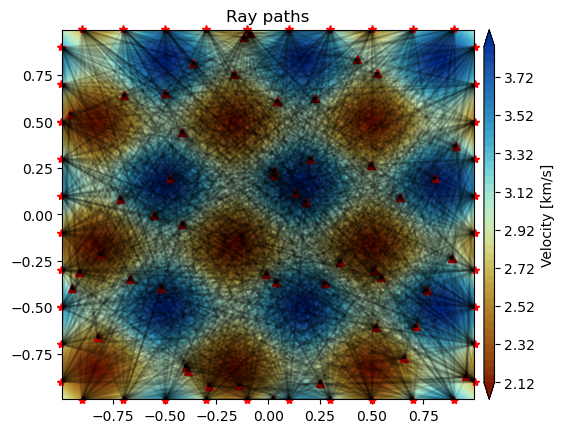

In [5]:
fig, ax = plt.subplots()
img = ax.tricontourf(*grid_points.T, 
                     vel_true, 
                     levels=50, 
                     cmap=scm.roma,
                     vmin=vel_true.min(),
                     vmax=vel_true.max(),
                     extend='both')
# Sources and receivers cols are lat, lon
ax.plot(sources[:,1], sources[:,0], 'r*', clip_on=False)
ax.plot(receivers[:,1], receivers[:,0], 'r^')
for lat1, lon1, lat2, lon2 in tomo.data_coords:
    ax.plot([lon1, lon2], [lat1, lat2], 'k', alpha=0.1)
ax.set_xlim(grid_points[:,0].min(), grid_points[:,0].max())
ax.set_ylim(grid_points[:,1].min(), grid_points[:,1].max())
cbar = fig.colorbar(img, ax=ax, aspect=35, pad=0.02)
cbar.set_label('Velocity [km/s]')
ax.set_title('Ray paths')
plt.show()

## Inference parameterization

In [6]:
vel = UniformPrior('vel', vmin=2, vmax=4, perturb_std=0.1)
voronoi = Voronoi2D(
    name='voronoi', 
    vmin=[tomo.grid.lonmin, tomo.grid.latmin], 
    vmax=[tomo.grid.lonmax, tomo.grid.latmax], 
    perturb_std=0.05, 
    n_dimensions_min=50, 
    n_dimensions_max=1500, 
    parameters=[vel], 
    compute_kdtree=True)
parameterization = bb.parameterization.Parameterization(voronoi)

## Log Likelihood

In [7]:
def _forward(kdtree, vel):
    nearest_neighbors = kdtree.query(grid_points)[1]
    interp_vel = vel[nearest_neighbors]
    return interp_vel, jacobian @ (1 / interp_vel)


def forward(state):
    voronoi = state["voronoi"]
    kdtree = voronoi.load_from_cache('kdtree')
    interp_vel, d_pred = _forward(kdtree, voronoi.get_param_values('vel'))
    state.save_to_extra_storage('interp_vel', interp_vel)
    return d_pred

In [ ]:
target = bb.likelihood.Target('d_obs', 
                              d_obs, 
                              std_min=0, 
                              std_max=0.01, 
                              std_perturb_std=0.001,
                              noise_is_correlated=False)
log_likelihood = bb.likelihood.LogLikelihood(targets=target, fwd_functions=forward)

## Bayesian Inference

In [9]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    log_likelihood=log_likelihood,
    n_chains=20
)
inversion.run(
    sampler=None, 
    n_iterations=75_000, 
    burnin_iterations=25_000, 
    save_every=250, 
    verbose=False,
    print_every=25_000
)

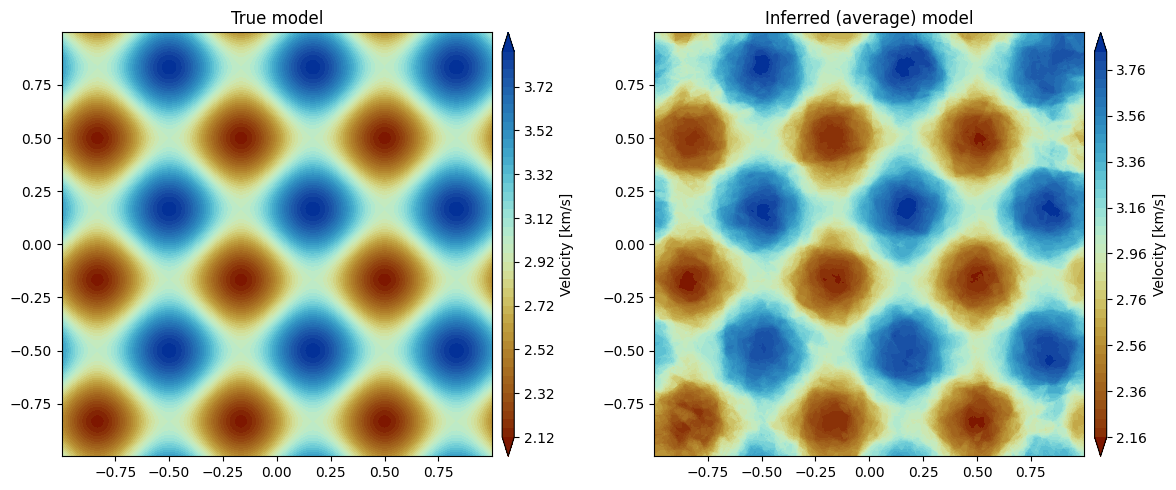

In [10]:
results = inversion.get_results()
inferred_vel = np.mean(results['interp_vel'], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
img = ax1.tricontourf(*grid_points.T, 
                     vel_true, 
                     levels=50, 
                     cmap=scm.roma,
                     vmin=vel_true.min(),
                     vmax=vel_true.max(),
                     extend='both')
ax1.set_xlim(grid_points[:,0].min(), grid_points[:,0].max())
ax1.set_ylim(grid_points[:,1].min(), grid_points[:,1].max())
cbar = fig.colorbar(img, ax=ax1, aspect=35, pad=0.02)
cbar.set_label('Velocity [km/s]')
ax1.set_title('True model')

img = ax2.tricontourf(*grid_points.T, 
                     inferred_vel, 
                     levels=50, 
                     cmap=scm.roma,
                     vmin=vel_true.min(),
                     vmax=vel_true.max(),
                     extend='both')
ax2.set_xlim(grid_points[:,0].min(), grid_points[:,0].max())
ax2.set_ylim(grid_points[:,1].min(), grid_points[:,1].max())
cbar = fig.colorbar(img, ax=ax2, aspect=35, pad=0.02)
ax2.set_title('Inferred (average) model')
cbar.set_label('Velocity [km/s]')

plt.tight_layout()
plt.show()

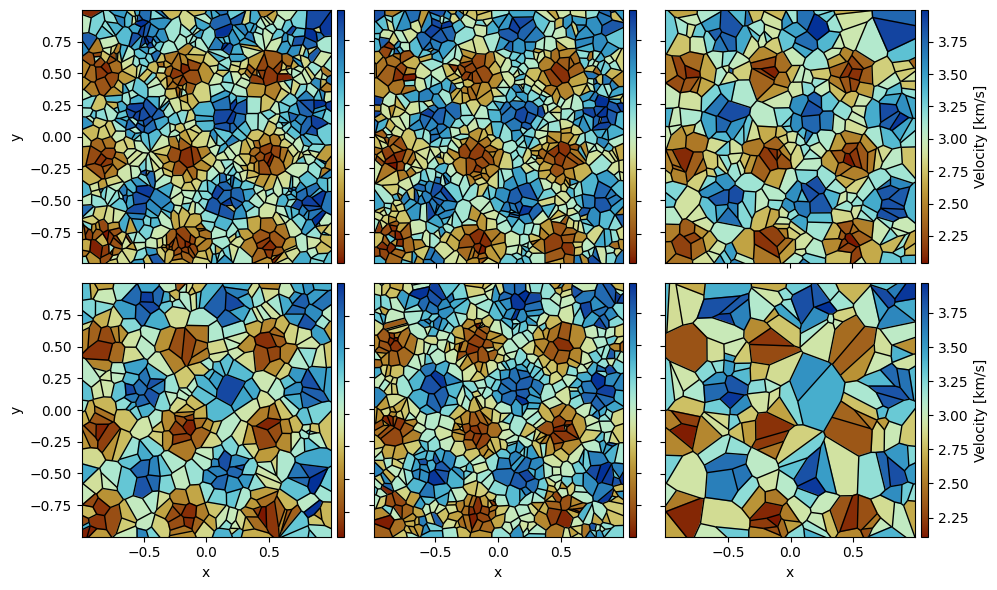

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
random_indexes = np.random.choice(range(len(results['voronoi.vel'])), size=9, replace=False)
for ipanel, (ax, irandom) in enumerate(zip(axes.ravel(), random_indexes)):
    voronoi_sites = results['voronoi.discretization'][irandom]
    velocity = results['voronoi.vel'][irandom]
    ax, cbar = Voronoi2D.plot_tessellation(
        voronoi_sites, 
        velocity, 
        ax=ax, 
        cmap=scm.roma,
        voronoi_sites_kwargs=dict(markersize=0)
    )
    ax.tick_params(labelleft=False, labelbottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    cbar.set_label('Velocity [km/s]')
    if ipanel in [0, 3]:
        ax.tick_params(labelleft=True)
        ax.set_ylabel('y')
    if ipanel not in [2, 5]:
        cbar.set_ticklabels('')
        cbar.set_label('')
    if ipanel>2:
        ax.set_xlabel('x')
        ax.tick_params(labelbottom=True)
plt.tight_layout()
plt.show()

## References

(Magrini22)=
[1] Magrini et al. (2022), Surface-wave tomography using SeisLib: a Python package for multiscale seismic imaging. *Geophysical Journal International*